##Installing Libraries

In [1]:
"!pip install tensorflow"
!pip install medmnist

##Importing Libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from medmnist import INFO
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [3]:
from medmnist import BreastMNIST

##Load Dataset

In [4]:
data_flag = 'breastmnist'

In [5]:
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
num_classes = len(info['label'])

In [6]:
print("Task: ",task)
print("Channels: ",n_channels)
print("Classes: ",num_classes)

Task:  binary-class
Channels:  1
Classes:  2


In [7]:
train_dataset = BreastMNIST(split="train", download=True, size=224)

In [8]:
test_dataset = BreastMNIST(split="test", size=224)

In [9]:
x_train = train_dataset.imgs
y_train = train_dataset.labels
x_test = test_dataset.imgs
y_test = test_dataset.labels

In [10]:
test_dataset

Dataset BreastMNIST of size 224 (breastmnist_224)
    Number of datapoints: 156
    Root location: /root/.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0

In [11]:
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

##PreProcessing

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize images to [0,1] range
    rotation_range=30,  # Random rotations
    width_shift_range=0.2,  # Random horizontal shifts
    height_shift_range=0.2,  # Random vertical shifts
    shear_range=0.2,  # Shear transformations
    zoom_range=0.2,  # Random zooms
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'  # Fill in any pixels that are created by the transformation
)


In [13]:
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [14]:
x_train = np.expand_dims(x_train, axis=-1).astype('float32')
x_test = np.expand_dims(x_test, axis=-1).astype('float32')

In [15]:
train_generator = train_datagen.flow(x_train, y_train, batch_size=32)

In [16]:
test_generator = test_datagen.flow(x_test, y_test, batch_size=32)

##Building CNN Model

In [17]:
import tensorflow as tf

model = tf.keras.Sequential([
    # Input Layer + Conv Block 1
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=(224, 224, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Conv Block 2
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Conv Block 3
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Conv Block 4 (optional deeper layer)
    tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Global Average Pooling instead of Flatten
    tf.keras.layers.GlobalAveragePooling2D(),

    # Dense Layer
    tf.keras.layers.Dense(128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.5),

    # Output Layer
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           25

 Total params: 423,426 (1.62 MB)

 Trainable params: 422,210 (1.61 MB)

 Non-trainable params: 1,216 (4.75 KB)

##Training

In [18]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),  # Use len(train_generator) to get the number of batches
    epochs=25,
    validation_data=test_generator,
    validation_steps=len(test_generator)  # Use len(test_generator) to get the number of batches
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.5353 - loss: 1.1756 - val_accuracy: 0.6154 - val_loss: 0.6892
Epoch 2/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.6837 - loss: 0.6692 - val_accuracy: 0.7179 - val_loss: 0.6605
Epoch 3/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.6459 - loss: 0.7431 - val_accuracy: 0.3782 - val_loss: 0.7205
Epoch 4/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.7391 - loss: 0.6441 - val_accuracy: 0.2692 - val_loss: 0.7990
Epoch 5/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.7213 - loss: 0.6426 - val_accuracy: 0.6731 - val_loss: 0.6552
Epoch 6/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - accuracy: 0.6876 - loss: 0.6950 - val_accuracy: 0.3846 - val_loss: 0.7258
Epoch 7/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.7230 - loss: 0.5965 - val_accuracy: 0.6538 - val_loss: 0.6445
Epoch 8/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 0.7631 - loss: 0.5613 - val_accuracy: 0

##Model Evaluation

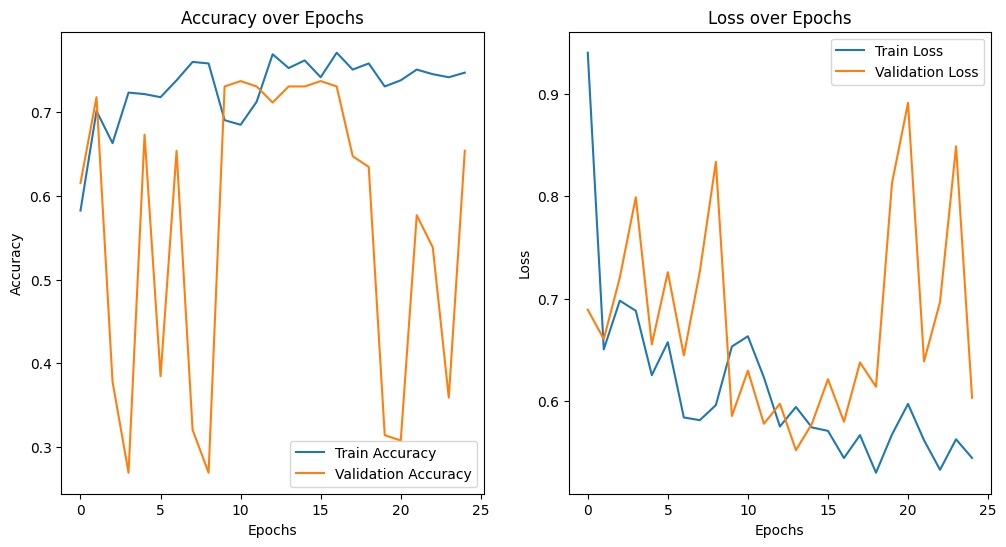

In [19]:
# Plot the training and validation accuracy/loss curves
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [20]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test Accuracy: {test_acc:.4f}')


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6811 - loss: 0.5920
Test Accuracy: 0.6538


##Making a prediction

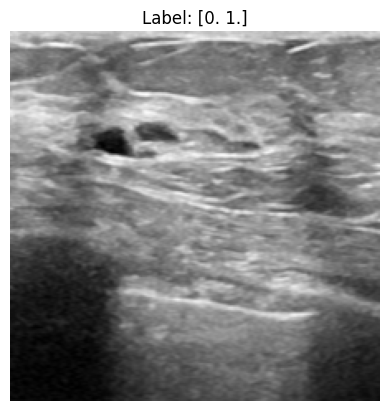

In [33]:
import random

n = random.randint(0,156)

image = x_test[n]  # Change the index to select a different image

# Display the image
plt.imshow(image.squeeze(), cmap='gray')  # `squeeze` removes the unnecessary color channels if it is grayscale
plt.title(f'Label: {y_train[0]}')  # Optionally display the label as the title
plt.axis('off')  # Hide axes
plt.show()

In [34]:
prediction = model.predict(np.expand_dims(image, axis=0))
predicted_class = np.argmax(prediction)
confidence = prediction[0][predicted_class]
print(f"Confidence for predicted class {predicted_class}: {confidence * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Confidence for predicted class 1: 100.00%


###Prediction from uploaded image

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the image file and convert it to grayscale
img = image.load_img('image file here', target_size=(224,224), color_mode='grayscale')

# Convert image to numpy array
img_array = image.img_to_array(img)

# Normalize the image
img_array = img_array.astype('float32') / 255

# Reshape the image to add the batch dimension (required for model input)
img_array = np.expand_dims(img_array, axis=0)

print(img_array.shape)

# Plot the image to confirm it's correctly loaded
plt.imshow(img_array[0], cmap='gray')
plt.show()

In [ ]:
prediction = model.predict(img_array)

predicted_class = np.argmax(prediction)

confidence = prediction[0][predicted_class]

print(f"Confidence for predicted class {predicted_class}: {confidence * 100:.2f}%")